In [4]:
import kagglehub

import os
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import pandas as pd

In [5]:
dataset_path = "./data/rafdb/"

if not os.path.exists(dataset_path):
    # Download latest version
    cache_path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
    print("Downloaded into cache at:", cache_path)

    # Now move to your desired directory
    os.makedirs(dataset_path, exist_ok=True)

    shutil.move(cache_path, dataset_path)
    print("Dataset now at:", dataset_path)

100%|██████████| 37.7M/37.7M [00:01<00:00, 27.3MB/s]

Extracting files...


Downloaded into cache at: /users/eleves-a/2025/iuliia.korotkova/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2
Dataset now at: ./data/rafdb/


In [8]:
class RAFDBDataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.root_dir = root_dir
        self.split = split
        self.dataset_dir = os.path.join(root_dir, "DATASET", split)
        self.labels_path = os.path.join(root_dir, f"{split}_labels.csv")

        df = pd.read_csv(self.labels_path)
        df.columns = ["filename", "label"]
        self.df = df

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        # emotion map
        self.emotions = {
            1: "surprise", 2: "fear", 3: "disgust",
            4: "happy", 5: "sad", 6: "anger", 7: "neutral"
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Images are organized in subdirectories by label: DATASET/{split}/{label}/{filename}
        img_path = os.path.join(self.dataset_dir, str(row.label), row.filename)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        emotion = self.emotions[row.label]

        # prompt = f"a portrait of a person showing {emotion} emotion"
        prompt = f"{emotion}"
        return {"pixel_values": image, "prompt": prompt}

In [9]:
dataset_path = "data/rafdb/2"
dataset = RAFDBDataset(dataset_path, split="test")

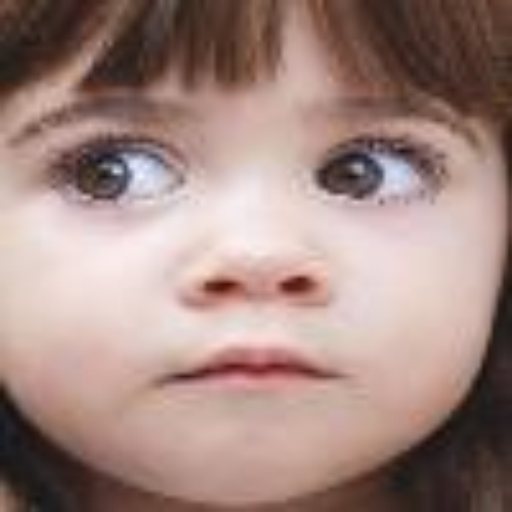

In [ ]:
pil_img = to_pil_image((dataset[1]["pixel_values"] * 0.5 + 0.5))
display(pil_img)

In [13]:
dataset[1]["pixel_values"].shape

torch.Size([3, 512, 512])

In [14]:
dataset[1]["prompt"]

'surprise'

In [6]:
from datasets import load_dataset

train_data_dir = "./data/rafdb_imagefolder"
cache_dir = None

data_files = {}
if train_data_dir is not None:
    data_files["train"] = os.path.join(train_data_dir, "**")
dataset = load_dataset(
    "imagefolder",
    data_files=data_files,
    cache_dir=cache_dir,
)

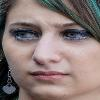

In [8]:
dataset["train"][0]["image"]